In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F

from tqdm.notebook import tqdm # progress bar


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 3 channels for RGB
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root="~/.pytorch/CIFAR10_data/", download=True, train=True, transform=transform)
testset = datasets.CIFAR10(root="~/.pytorch/CIFAR10_data/", download=True, train=False, transform=transform)


100%|████████████████████████████████████████████████████████████████████████████████| 170M/170M [05:27<00:00, 521kB/s]


Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64


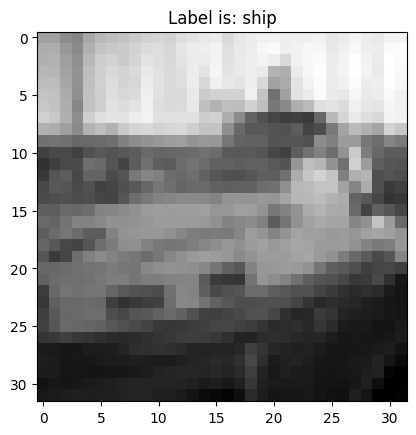

In [24]:
batch_size = 64

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create data loaders.
train_dataloader = DataLoader(trainset, batch_size=batch_size)
test_dataloader = DataLoader(testset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    
    # plt.imshow(X[0].reshape(28,28))
    index = np.random.randint(0, 8)
    plt.imshow(X[index][0], cmap="gray")
    
    plt.title(f"Label is: {class_names[y[index]]}")
    plt.show()
    
    break


In [28]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


## Model

In [26]:
# Generator for DCGAN
class Generator(nn.Module):
    def __init__(self, latent_dim, feature_maps=64, channels=3):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_maps * 8, 4, 1, 0, bias=False), # upsamples
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),

            # Shape: (feature_maps*8) x 4 x 4
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),

            # Shape: (feature_maps*4) x 8 x 8
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),

            # Shape: (feature_maps*2) x 16 x 16
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # Shape: (feature_maps) x 32 x 32
            nn.ConvTranspose2d(feature_maps, channels, 3, 1, 1, bias=False),
            nn.Tanh()  # Output shape: channels x 32 x 32
        )

    def forward(self, z):
        return self.net(z)

# Discriminator for DCGAN
class Discriminator(nn.Module):
    def __init__(self, feature_maps=64, channels=3):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Input: channels x 32 x 32
            nn.Conv2d(channels, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 8, 1, 2, 1, 0, bias=False),  # Output is 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)


## Training

[Epoch 1/1]  D loss: 0.8655  G loss: 1.0349


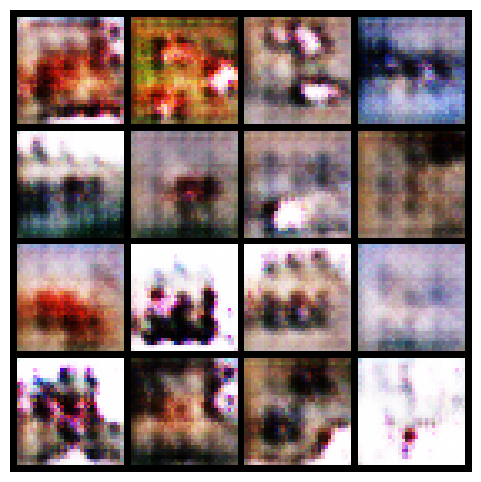

In [29]:
# Parameters
latent_dim = 100
lr = 0.0002
num_epochs = 1

# Image dimensions for CIFAR-10
img_channels = 3
img_size = 32

# Initialize models
G = Generator(latent_dim, feature_maps=64, channels=img_channels).to(device)
D = Discriminator(feature_maps=64, channels=img_channels).to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(train_dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(z)

        real_loss = criterion(D(real_imgs), real_labels)
        fake_loss = criterion(D(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(z)
        g_loss = criterion(D(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"[Epoch {epoch+1}/{num_epochs}]  D loss: {d_loss.item():.4f}  G loss: {g_loss.item():.4f}")

    # Show sample images
    if (epoch + 1) % 1 == 0:
        G.eval()
        with torch.no_grad():
            z = torch.randn(16, latent_dim, 1, 1, device=device)
            samples = G(z)
            samples = samples * 0.5 + 0.5  # rescale from [-1,1] to [0,1]
            grid = torchvision.utils.make_grid(samples, nrow=4, normalize=False)
            plt.figure(figsize=(6,6))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis("off")
            plt.show()
        G.train()
